$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

Build the pipeline to get the data into STAN.

In [1]:
using Stan

using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
using DataFrames: by, head
using Base.Dates: tonext, Hour, Day
using Distributions
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data import and preprocessing

In [3]:
include("iowa.jl")
iowa = prepare_iowa_data(data_dir);

# Visualizing Test Data: Tn and Tx

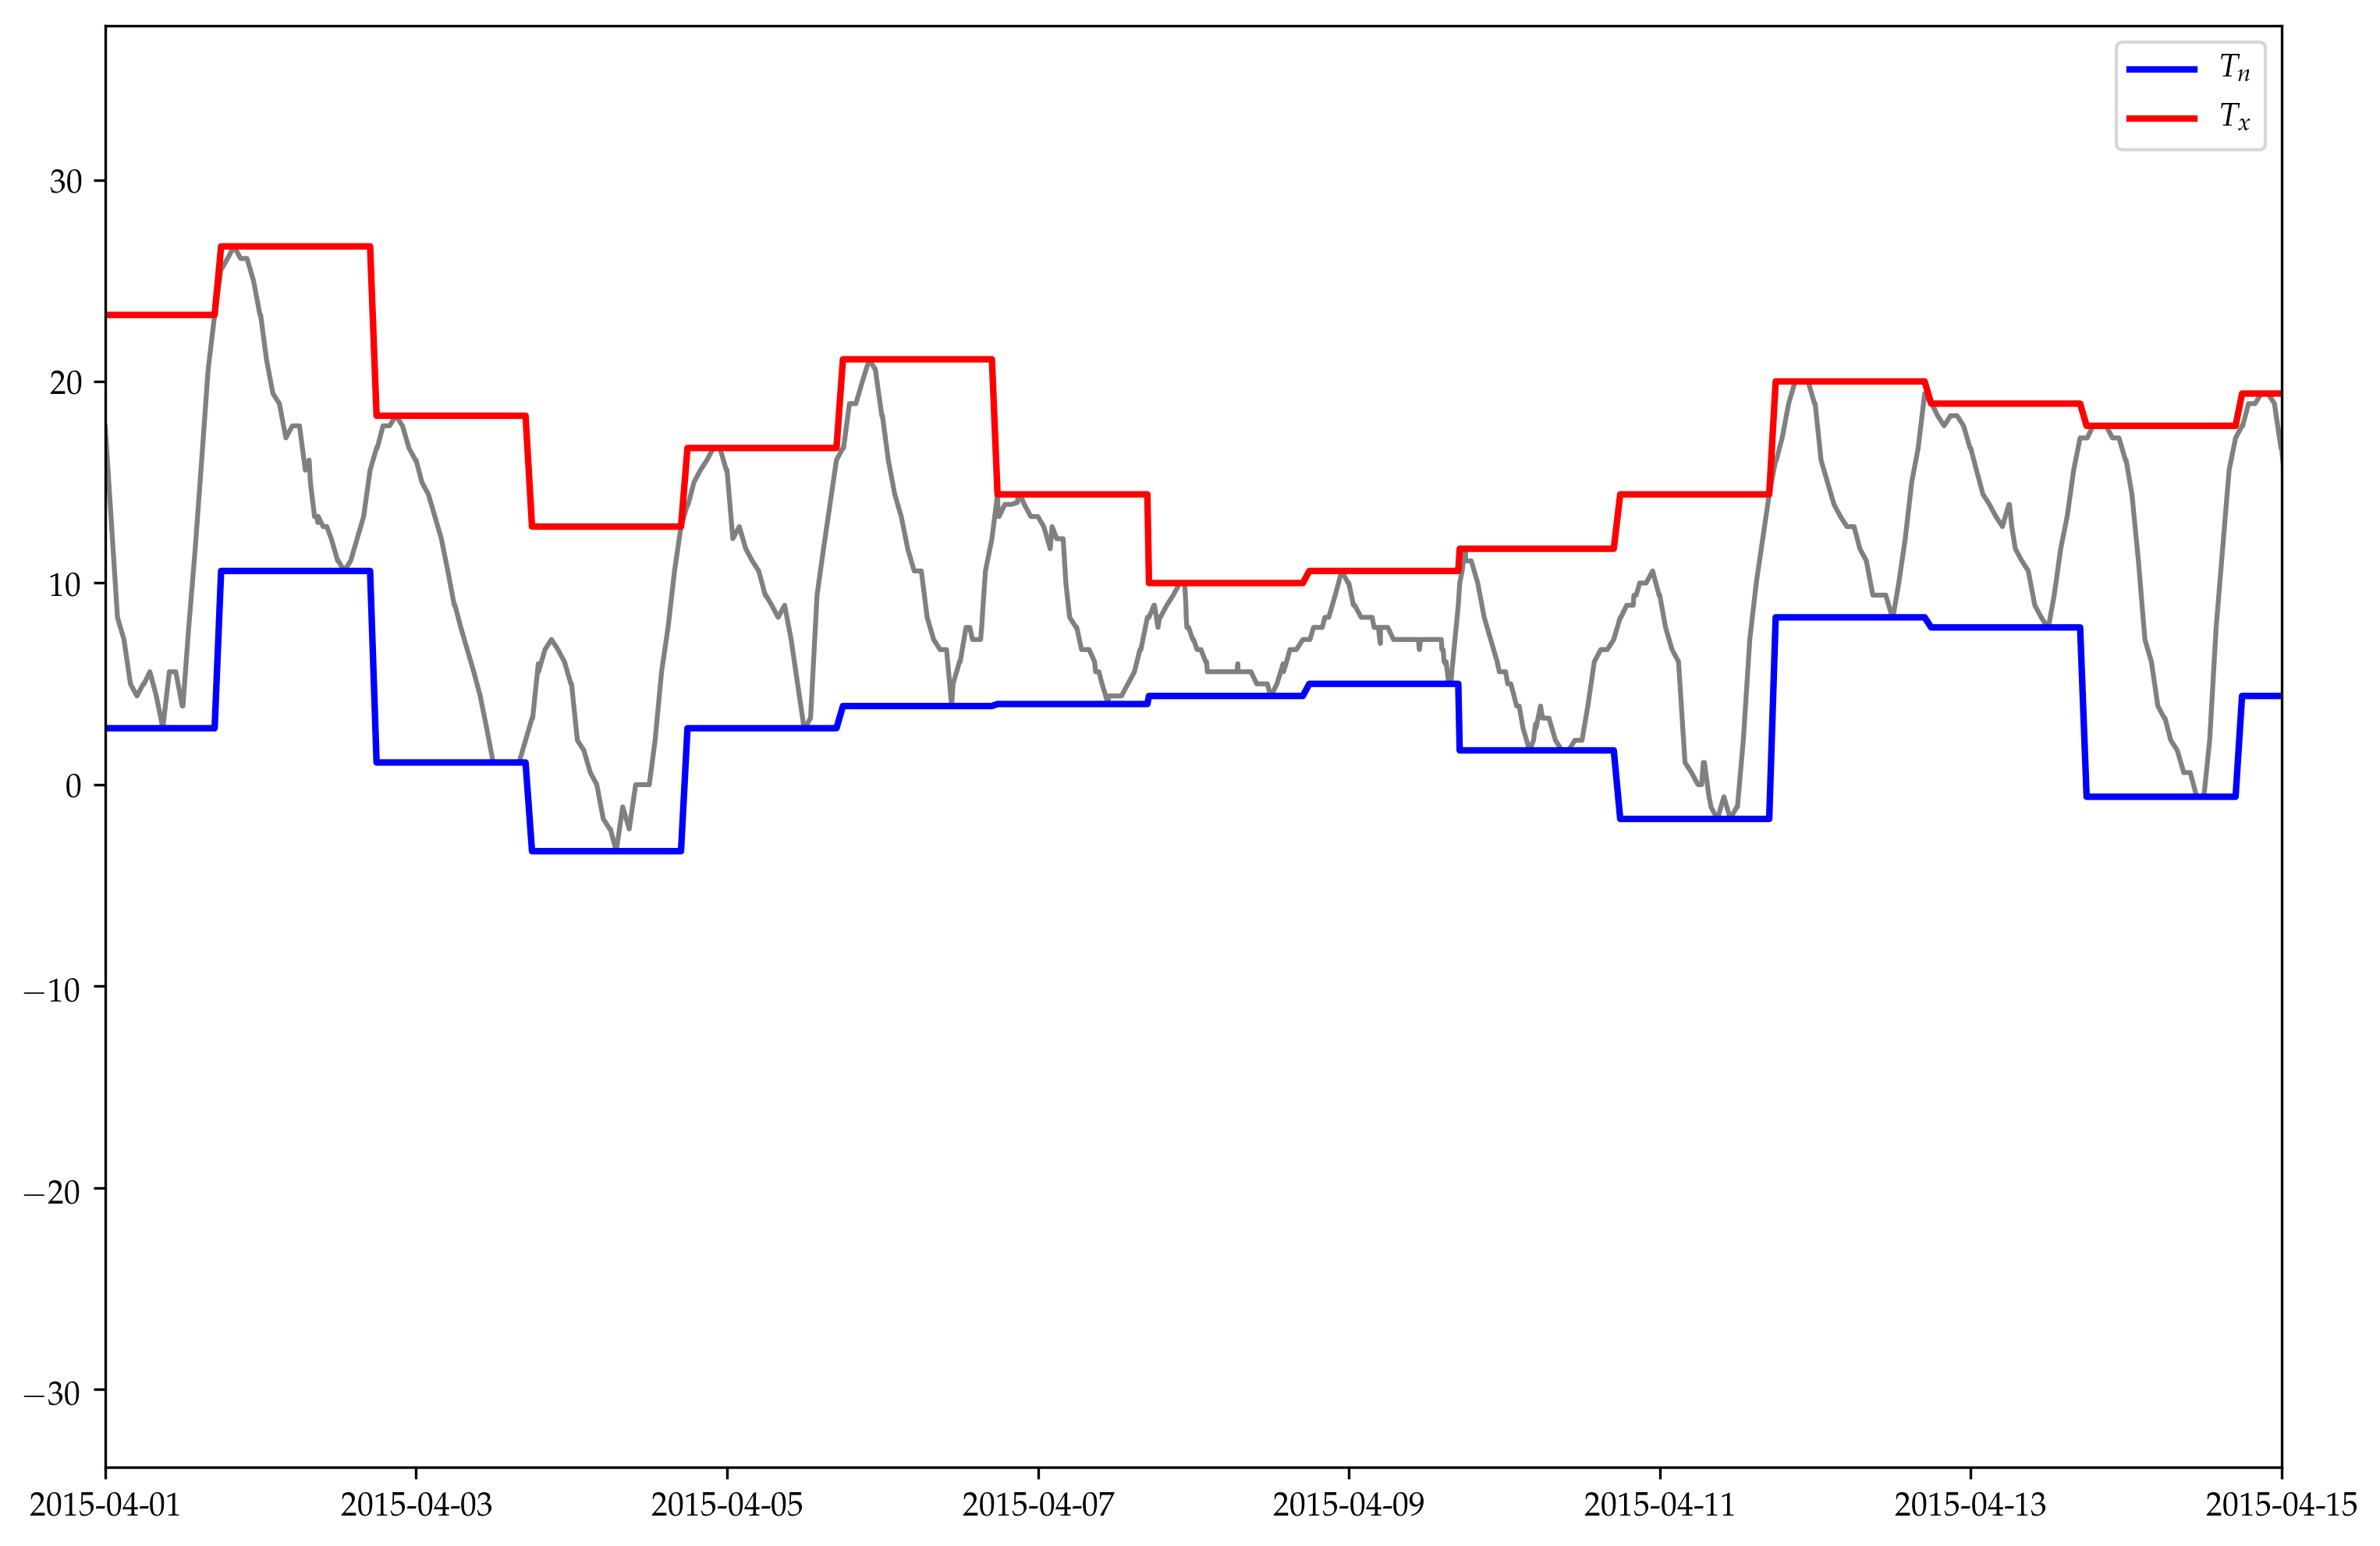

In [4]:
let
    test = iowa[:hourly_test]
    plt.plot(test[:ts], test[:temp], color="grey")
    plt.plot(test[:ts], test[:Tn], color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test[:ts], test[:Tx], color="red", linewidth=2, label=L"$T_x$")
    plt.xlim(DateTime(2015,4,1),DateTime(2015,4,15)) # random interval
    plt.legend()
end
;

# Kernel Specification

In [5]:
k_spatiotemporal, logNoise = TempModel.fitted_sptemp_SExSE()

(Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [0.996834, 1.3172]
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [12.0805]
  Type: GaussianProcesses.FixedKern, Params: Float64[]
, -0.822261)

# Fitting GP on training data

In [6]:
dt_start, dt_end = DateTime(2015,5,25,18,0,0), DateTime(2015,6,3,16,0,0)
train_subset = TempModel.subset(iowa[:hourly_train], dt_start, dt_end)
test_subset  = TempModel.subset(iowa[:hourly_test],  dt_start, dt_end)

avgtemp=by(train_subset, :station, df->DataFrame(avgtemp=mean(df[:temp])))
train_subset = join(train_subset, avgtemp, on=:station)

train_X_PRJ = iowa[:isdSubset][:X_PRJ][train_subset[:station]]
train_Y_PRJ = iowa[:isdSubset][:Y_PRJ][train_subset[:station]]
train_X = [train_subset[:ts_hours] train_X_PRJ train_Y_PRJ]
train_Y = train_subset[:temp] .- train_subset[:avgtemp]

test_X_PRJ = iowa[:isdSubset][:X_PRJ][test_subset[:station]]
test_Y_PRJ = iowa[:isdSubset][:Y_PRJ][test_subset[:station]]
test_X = [test_subset[:ts_hours] test_X_PRJ test_Y_PRJ]
;

In [7]:
train_GP = GP(train_X', train_Y, MeanZero(), k_spatiotemporal, logNoise);

In [8]:
prior_GP = GP(zeros(3,0), zeros(0), MeanZero(), k_spatiotemporal, logNoise);

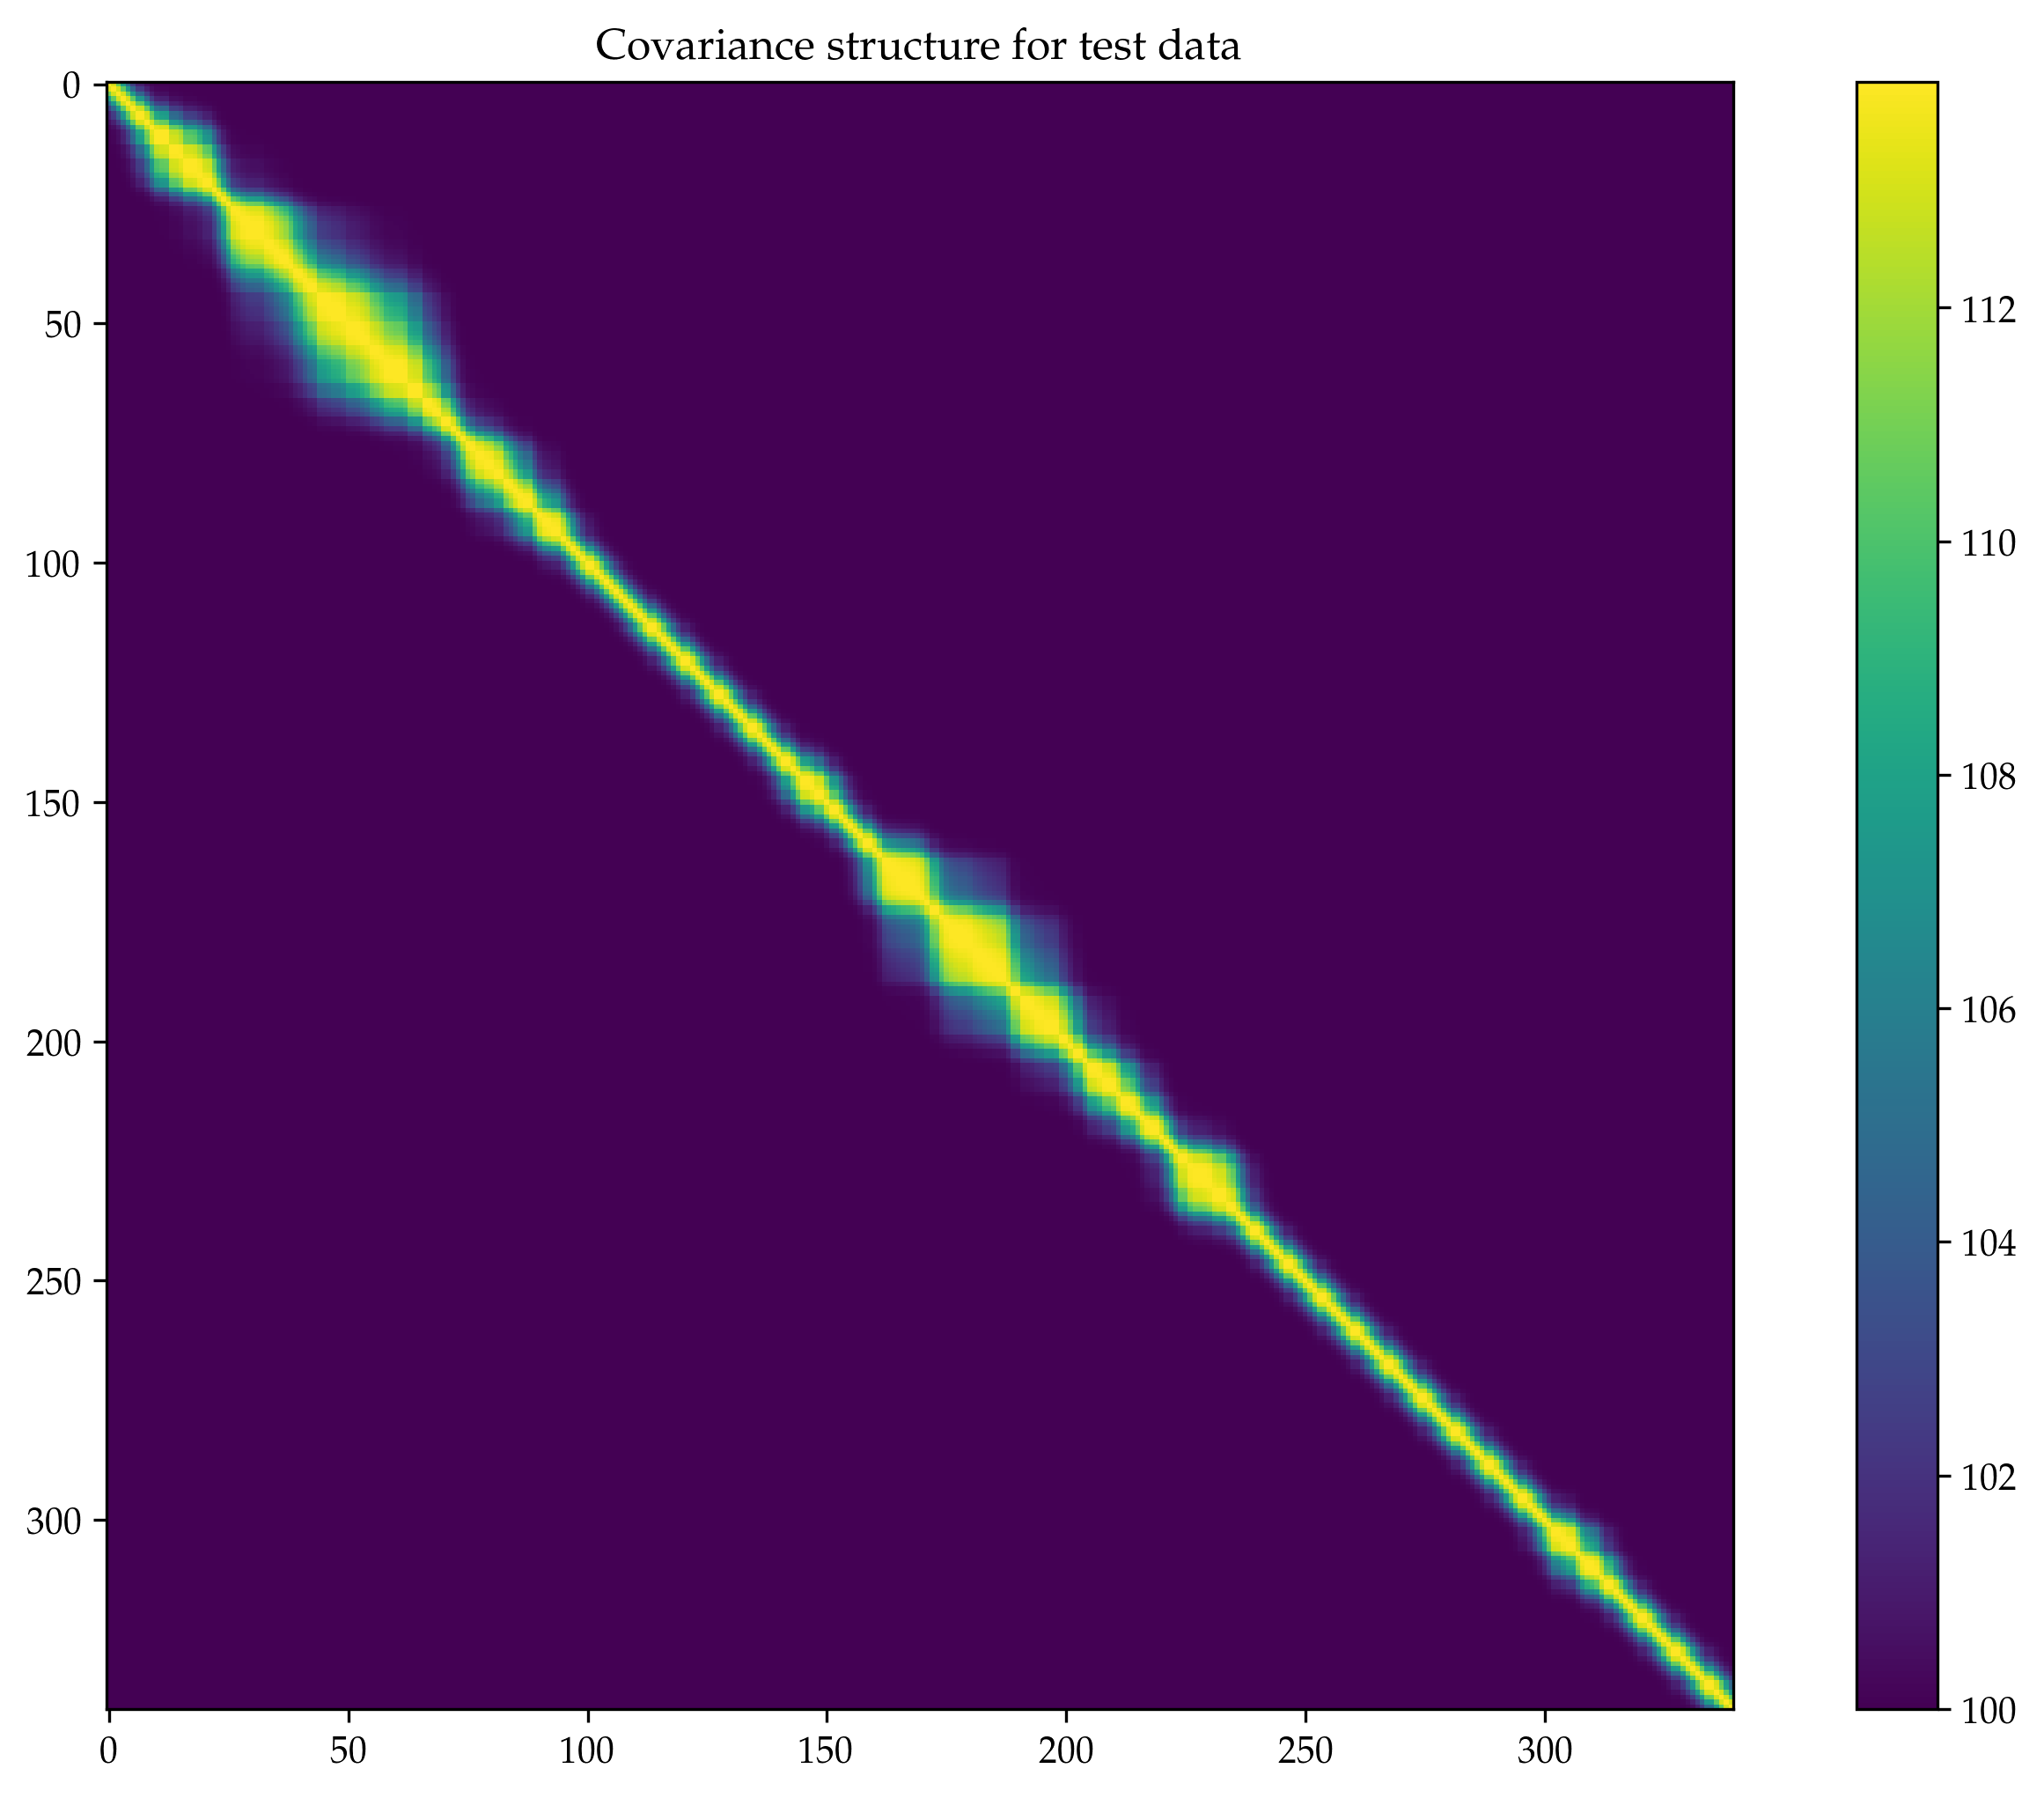

PyObject <matplotlib.colorbar.Colorbar object at 0x1307dff60>

In [9]:
plt.imshow(cov(k_spatiotemporal, test_X'))
plt.title("Covariance structure for test data")
plt.colorbar()

## Predicting at the test location

In [10]:
test_prediction=predict_f(train_GP, test_X'; full_cov=true)
prior_prediction=predict_f(prior_GP, test_X'; full_cov=true)
TempModel.add_diag!(test_prediction[2], exp(2*logNoise))
TempModel.add_diag!(prior_prediction[2], exp(2*logNoise))
;

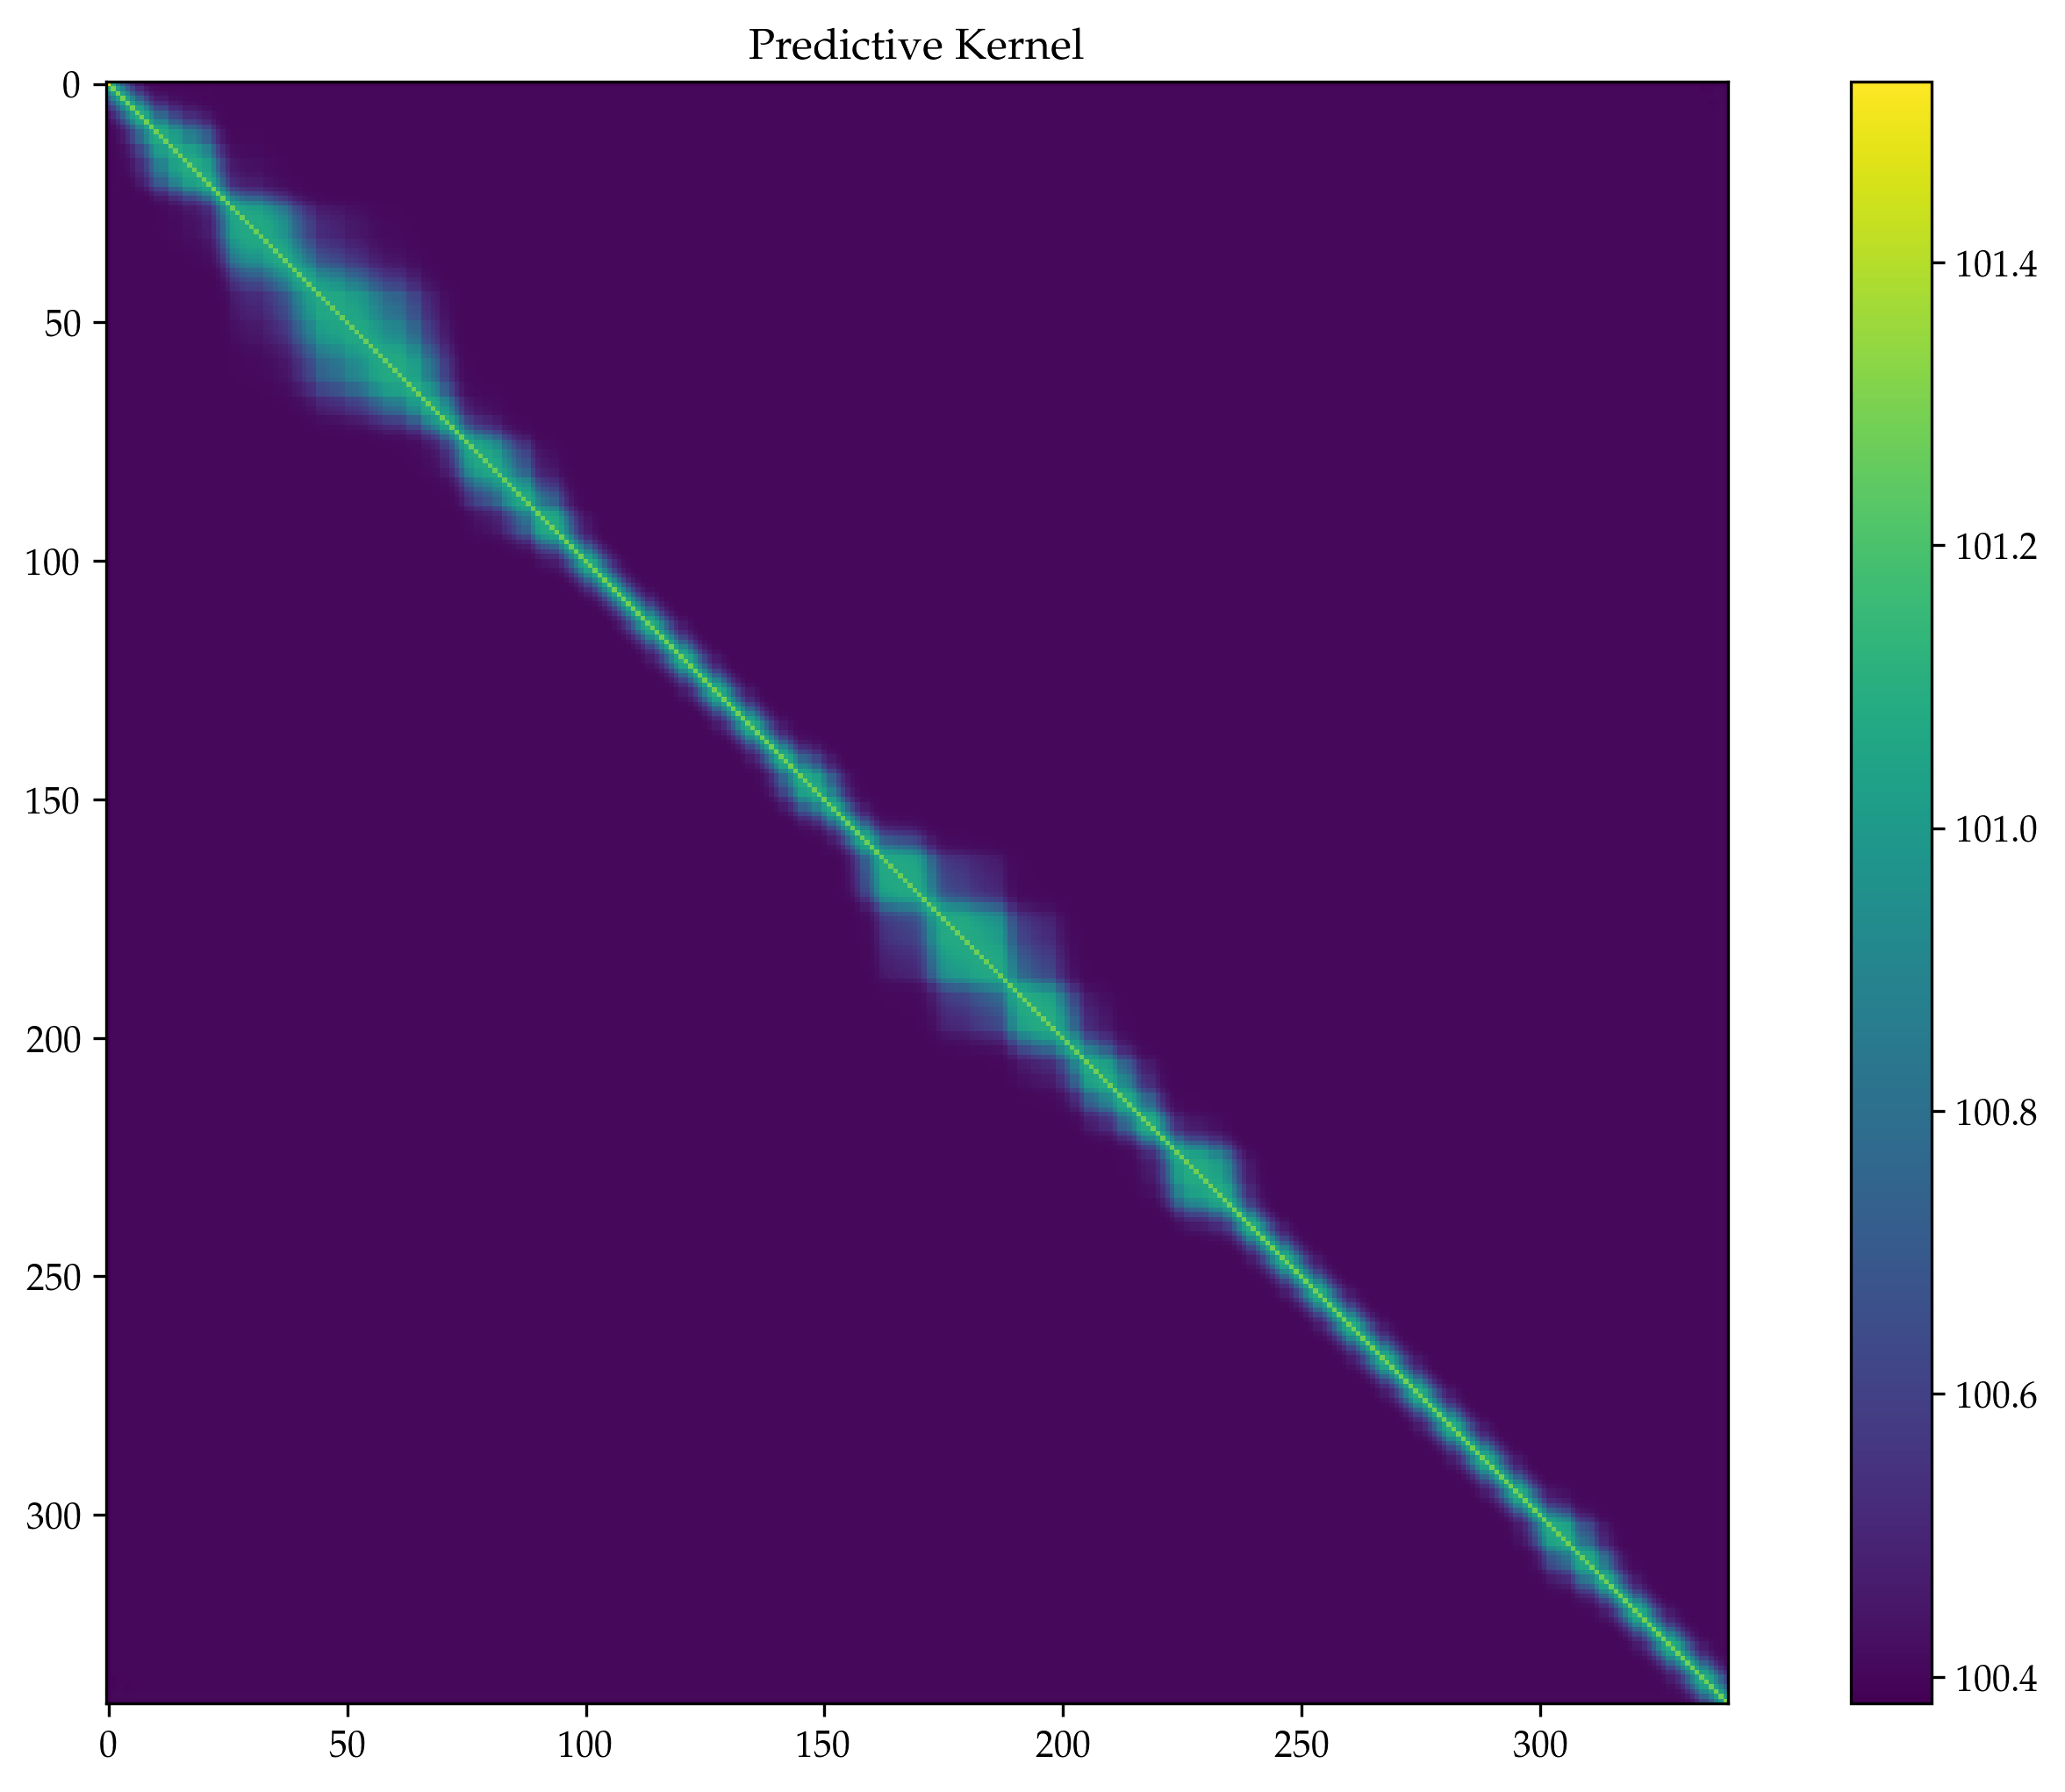

PyObject <matplotlib.colorbar.Colorbar object at 0x13939c198>

In [11]:
begin
    plt.imshow(test_prediction[2].mat)
    plt.title("Predictive Kernel")
    plt.colorbar()
end

## Predictive draws

Let's show some draws from the posterior fitted using the hourly data at nearby stations, but *not* the $T_n$ and $T_x$ records.

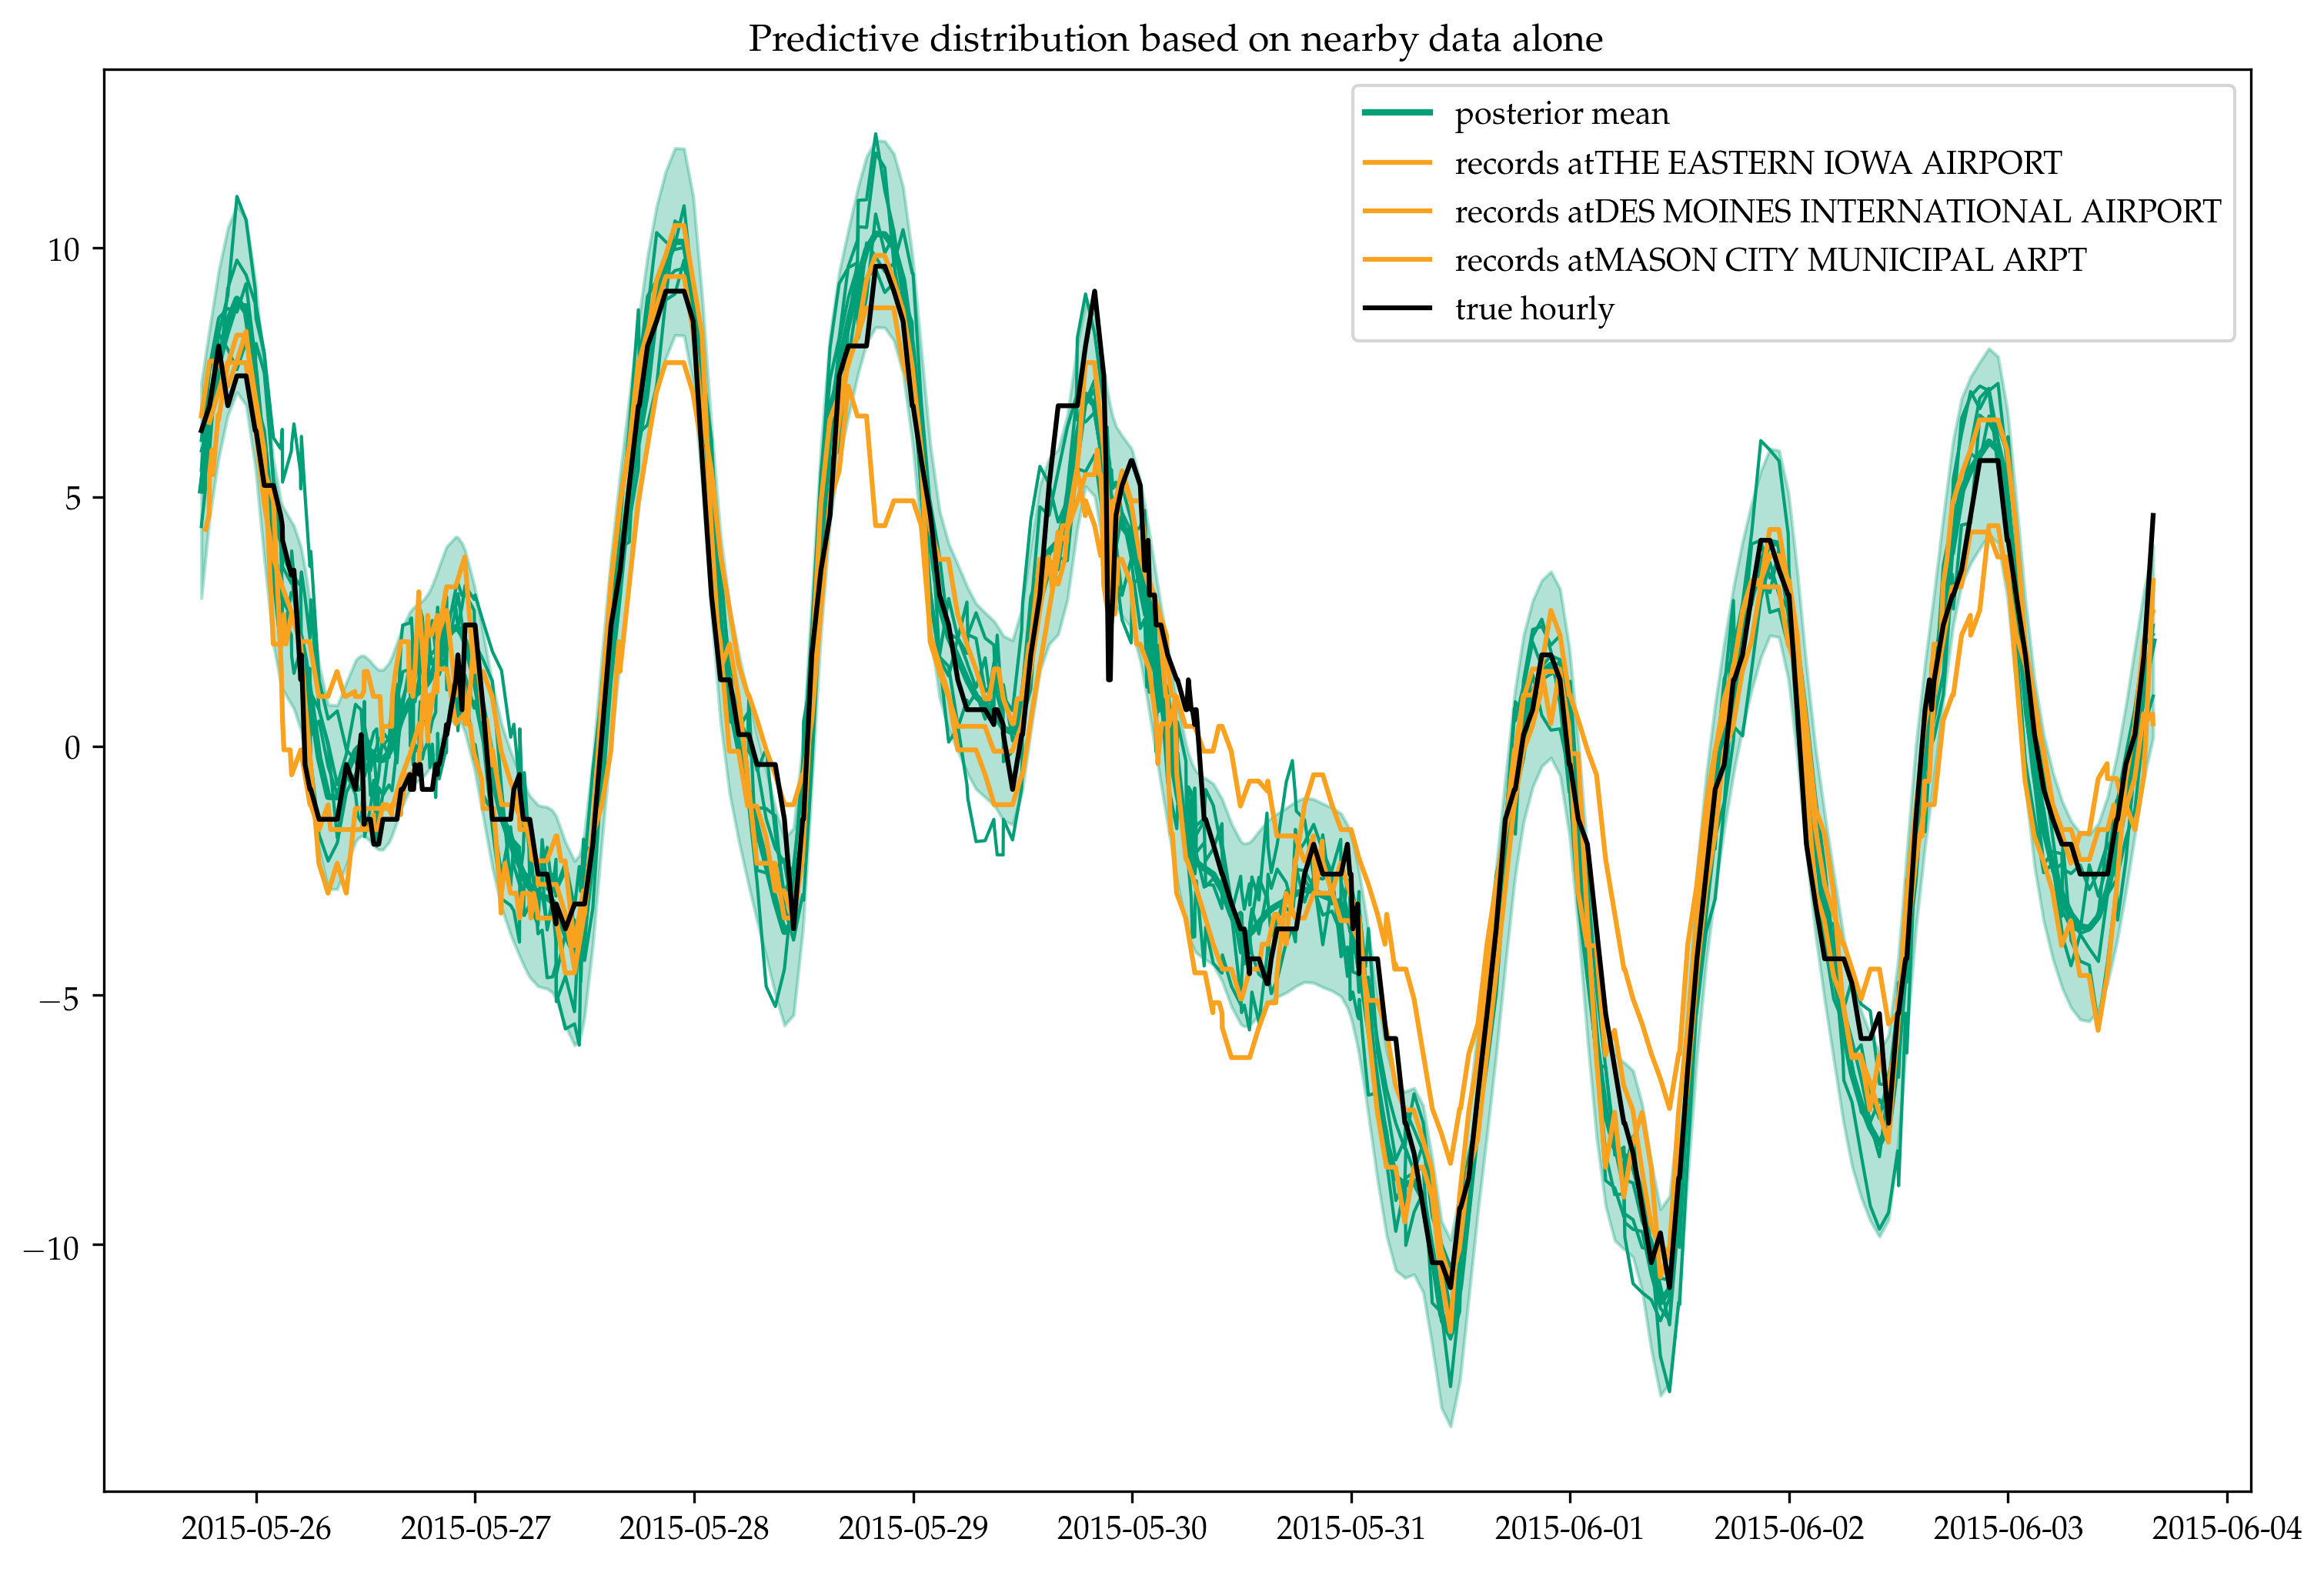

In [12]:
begin
    ts=test_subset[:ts]
    μ = test_prediction[1]
    Σ = test_prediction[2]
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:5
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    y_err = sqrt.(diag(Σ_centered))
    plt.fill_between(ts, μ-2*y_err,μ+2*y_err, color="#009F77", alpha=0.3)
    for station in unique(train_subset[:station])
        sdata = train_subset[train_subset[:station].==station,:]
        ts=sdata[:ts]
        plt.plot(ts, sdata[:temp].-mean(sdata[:temp]), color="#F8A21F", 
            label="records at"iowa[:isdSubset][station,:NAME])
    end
    ts = test_subset[:ts]
    temp_true = test_subset[:temp]
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
end
;

It's interesting to note that the posterior mean is quite close to the truth, despite the very wide credible envelope. To me this suggests that the information available from nearby stations is underweighted. We should be making more confident predictions.

# Specifying STAN model

In [13]:
imputation_model = TempModel.get_imputation_model()
;

## preparing Stan data

In [14]:
test_TxTn = by(test_subset, :ts_day, df -> DataFrame(
    Tn=first(df[:Tn]), 
    Tx=first(df[:Tx]), 
    times_p_day=nrow(df),
))

,ts_day,Tn,Tx,times_p_day
1,2015-05-26,15.6,25.6,46
2,2015-05-27,13.9,22.8,54
3,2015-05-28,13.9,26.7,27
4,2015-05-29,16.7,27.2,31
5,2015-05-30,12.8,26.7,59
6,2015-05-31,6.7,16.1,36
7,2015-06-01,6.7,19.4,28
8,2015-06-02,10.0,21.7,32
9,2015-06-03,15.0,23.9,27


In [15]:
ts_day = test_subset[:ts_day]
day_impute = Int.( (ts_day .- minimum(ts_day)) ./ Dates.Day(1) ) .+ 1
imputation_data = Dict(
    "N_TxTn" => nrow(test_TxTn),
    "Tn" => test_TxTn[:Tn],
    "Tx" => test_TxTn[:Tx],
    "Nimpt" => nrow(test_subset),
    "day_impute" => day_impute,
    "impt_times_p_day" => test_TxTn[:times_p_day],
    "predicted_mean" => test_prediction[1],
    "predicted_cov" => test_prediction[2].mat,
    "predicted_cov_chol" => full(test_prediction[2].chol[:L]),
    "k_smoothmax" => 10.0,
    
)

Dict{String,Any} with 10 entries:
  "Tx"                 => [25.6, 22.8, 26.7, 27.2, 26.7, 16.1, 19.4, 21.7, 23.9]
  "k_smoothmax"        => 10.0
  "predicted_cov_chol" => [10.0761 0.0 … 0.0 0.0; 10.032 0.809554 … 0.0 0.0; … …
  "impt_times_p_day"   => [46, 54, 27, 31, 59, 36, 28, 32, 27]
  "Nimpt"              => 340
  "Tn"                 => [15.6, 13.9, 13.9, 16.7, 12.8, 6.7, 6.7, 10.0, 15.0]
  "N_TxTn"             => 9
  "day_impute"         => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  9, 9, 9, 9, 9, 9, 9…
  "predicted_cov"      => [101.528 101.084 … 100.388 100.381; 101.084 101.297 ……
  "predicted_mean"     => [5.13125, 6.48652, 7.66563, 8.52217, 8.97763, 8.71282…

# Running STAN

In [16]:
@time sim1 = stan(imputation_model, [imputation_data], 
    CmdStanDir=Stan.CMDSTAN_HOME, summary=false, diagnostics=false);


make: `/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your

1728.230611 seconds (5.74 M allocations: 542.966 MiB, 0.02% gc time)


In [17]:
using AxisArrays
function Chains(samples::AbstractArray{Float64, 3}, names::AbstractVector{S}) where {S<:AbstractString}
    nsamples, ncol, nchains = size(samples)
    chains = AxisArray(samples, Axis{:sample}(1:nsamples), Axis{:param}(names), Axis{:chain}(1:nchains))
    return chains
end
function get_param_names(chains::AxisArray)
    # there should be a more elegant way to obtain the names of an axis
    PARAM = Axis{:param}
    jparam = axisdim(chains, PARAM)
    param_axis = axes(chains)[jparam]
    param_names = axisvalues(param_axis)[1]
    return param_names
end
function get_temperatures_reparam(chains::AxisArray)
    # next 4 lines: tedious way to get names of parameters
    param_names = get_param_names(chains)
    temp_varnames = [h for h in param_names if startswith(h, "temp_impt.")]
    temp_samples = view(chains, :, Axis{:param}(temp_varnames), :)
    return temp_samples
end
header = split("lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,w_uncorr.1,w_uncorr.2,w_uncorr.3,w_uncorr.4,w_uncorr.5,w_uncorr.6,w_uncorr.7,w_uncorr.8,w_uncorr.9,w_uncorr.10,w_uncorr.11,w_uncorr.12,w_uncorr.13,w_uncorr.14,w_uncorr.15,w_uncorr.16,w_uncorr.17,w_uncorr.18,w_uncorr.19,w_uncorr.20,w_uncorr.21,w_uncorr.22,w_uncorr.23,w_uncorr.24,w_uncorr.25,w_uncorr.26,w_uncorr.27,w_uncorr.28,w_uncorr.29,w_uncorr.30,w_uncorr.31,w_uncorr.32,w_uncorr.33,w_uncorr.34,w_uncorr.35,w_uncorr.36,w_uncorr.37,w_uncorr.38,w_uncorr.39,w_uncorr.40,w_uncorr.41,w_uncorr.42,w_uncorr.43,w_uncorr.44,w_uncorr.45,w_uncorr.46,w_uncorr.47,w_uncorr.48,w_uncorr.49,w_uncorr.50,w_uncorr.51,w_uncorr.52,w_uncorr.53,w_uncorr.54,w_uncorr.55,w_uncorr.56,w_uncorr.57,w_uncorr.58,w_uncorr.59,w_uncorr.60,w_uncorr.61,w_uncorr.62,w_uncorr.63,w_uncorr.64,w_uncorr.65,w_uncorr.66,w_uncorr.67,w_uncorr.68,w_uncorr.69,w_uncorr.70,w_uncorr.71,w_uncorr.72,w_uncorr.73,w_uncorr.74,w_uncorr.75,w_uncorr.76,w_uncorr.77,w_uncorr.78,w_uncorr.79,w_uncorr.80,w_uncorr.81,w_uncorr.82,w_uncorr.83,w_uncorr.84,w_uncorr.85,w_uncorr.86,w_uncorr.87,w_uncorr.88,w_uncorr.89,w_uncorr.90,w_uncorr.91,w_uncorr.92,w_uncorr.93,w_uncorr.94,w_uncorr.95,w_uncorr.96,w_uncorr.97,w_uncorr.98,w_uncorr.99,w_uncorr.100,w_uncorr.101,w_uncorr.102,w_uncorr.103,w_uncorr.104,w_uncorr.105,w_uncorr.106,w_uncorr.107,w_uncorr.108,w_uncorr.109,w_uncorr.110,w_uncorr.111,w_uncorr.112,w_uncorr.113,w_uncorr.114,w_uncorr.115,w_uncorr.116,w_uncorr.117,w_uncorr.118,w_uncorr.119,w_uncorr.120,w_uncorr.121,w_uncorr.122,w_uncorr.123,w_uncorr.124,w_uncorr.125,w_uncorr.126,w_uncorr.127,w_uncorr.128,w_uncorr.129,w_uncorr.130,w_uncorr.131,w_uncorr.132,w_uncorr.133,w_uncorr.134,w_uncorr.135,w_uncorr.136,w_uncorr.137,w_uncorr.138,w_uncorr.139,w_uncorr.140,w_uncorr.141,w_uncorr.142,w_uncorr.143,w_uncorr.144,w_uncorr.145,w_uncorr.146,w_uncorr.147,w_uncorr.148,w_uncorr.149,w_uncorr.150,w_uncorr.151,w_uncorr.152,w_uncorr.153,w_uncorr.154,w_uncorr.155,w_uncorr.156,w_uncorr.157,w_uncorr.158,w_uncorr.159,w_uncorr.160,w_uncorr.161,w_uncorr.162,w_uncorr.163,w_uncorr.164,w_uncorr.165,w_uncorr.166,w_uncorr.167,w_uncorr.168,w_uncorr.169,w_uncorr.170,w_uncorr.171,w_uncorr.172,w_uncorr.173,w_uncorr.174,w_uncorr.175,w_uncorr.176,w_uncorr.177,w_uncorr.178,w_uncorr.179,w_uncorr.180,w_uncorr.181,w_uncorr.182,w_uncorr.183,w_uncorr.184,w_uncorr.185,w_uncorr.186,w_uncorr.187,w_uncorr.188,w_uncorr.189,w_uncorr.190,w_uncorr.191,w_uncorr.192,w_uncorr.193,w_uncorr.194,w_uncorr.195,w_uncorr.196,w_uncorr.197,w_uncorr.198,w_uncorr.199,w_uncorr.200,w_uncorr.201,w_uncorr.202,w_uncorr.203,w_uncorr.204,w_uncorr.205,w_uncorr.206,w_uncorr.207,w_uncorr.208,w_uncorr.209,w_uncorr.210,w_uncorr.211,w_uncorr.212,w_uncorr.213,w_uncorr.214,w_uncorr.215,w_uncorr.216,w_uncorr.217,w_uncorr.218,w_uncorr.219,w_uncorr.220,w_uncorr.221,w_uncorr.222,w_uncorr.223,w_uncorr.224,w_uncorr.225,w_uncorr.226,w_uncorr.227,w_uncorr.228,w_uncorr.229,w_uncorr.230,w_uncorr.231,w_uncorr.232,w_uncorr.233,w_uncorr.234,w_uncorr.235,w_uncorr.236,w_uncorr.237,w_uncorr.238,w_uncorr.239,w_uncorr.240,w_uncorr.241,w_uncorr.242,w_uncorr.243,w_uncorr.244,w_uncorr.245,w_uncorr.246,w_uncorr.247,w_uncorr.248,w_uncorr.249,w_uncorr.250,w_uncorr.251,w_uncorr.252,w_uncorr.253,w_uncorr.254,w_uncorr.255,w_uncorr.256,w_uncorr.257,w_uncorr.258,w_uncorr.259,w_uncorr.260,w_uncorr.261,w_uncorr.262,w_uncorr.263,w_uncorr.264,w_uncorr.265,w_uncorr.266,w_uncorr.267,w_uncorr.268,w_uncorr.269,w_uncorr.270,w_uncorr.271,w_uncorr.272,w_uncorr.273,w_uncorr.274,w_uncorr.275,w_uncorr.276,w_uncorr.277,w_uncorr.278,w_uncorr.279,w_uncorr.280,w_uncorr.281,w_uncorr.282,w_uncorr.283,w_uncorr.284,w_uncorr.285,w_uncorr.286,w_uncorr.287,w_uncorr.288,w_uncorr.289,w_uncorr.290,w_uncorr.291,w_uncorr.292,w_uncorr.293,w_uncorr.294,w_uncorr.295,w_uncorr.296,w_uncorr.297,w_uncorr.298,w_uncorr.299,w_uncorr.300,w_uncorr.301,w_uncorr.302,w_uncorr.303,w_uncorr.304,w_uncorr.305,w_uncorr.306,w_uncorr.307,w_uncorr.308,w_uncorr.309,w_uncorr.310,w_uncorr.311,w_uncorr.312,w_uncorr.313,w_uncorr.314,w_uncorr.315,w_uncorr.316,w_uncorr.317,w_uncorr.318,w_uncorr.319,w_uncorr.320,w_uncorr.321,w_uncorr.322,w_uncorr.323,w_uncorr.324,w_uncorr.325,w_uncorr.326,w_uncorr.327,w_uncorr.328,w_uncorr.329,w_uncorr.330,w_uncorr.331,w_uncorr.332,w_uncorr.333,w_uncorr.334,w_uncorr.335,w_uncorr.336,w_uncorr.337,w_uncorr.338,w_uncorr.339,w_uncorr.340,mu,temp_impt.1,temp_impt.2,temp_impt.3,temp_impt.4,temp_impt.5,temp_impt.6,temp_impt.7,temp_impt.8,temp_impt.9,temp_impt.10,temp_impt.11,temp_impt.12,temp_impt.13,temp_impt.14,temp_impt.15,temp_impt.16,temp_impt.17,temp_impt.18,temp_impt.19,temp_impt.20,temp_impt.21,temp_impt.22,temp_impt.23,temp_impt.24,temp_impt.25,temp_impt.26,temp_impt.27,temp_impt.28,temp_impt.29,temp_impt.30,temp_impt.31,temp_impt.32,temp_impt.33,temp_impt.34,temp_impt.35,temp_impt.36,temp_impt.37,temp_impt.38,temp_impt.39,temp_impt.40,temp_impt.41,temp_impt.42,temp_impt.43,temp_impt.44,temp_impt.45,temp_impt.46,temp_impt.47,temp_impt.48,temp_impt.49,temp_impt.50,temp_impt.51,temp_impt.52,temp_impt.53,temp_impt.54,temp_impt.55,temp_impt.56,temp_impt.57,temp_impt.58,temp_impt.59,temp_impt.60,temp_impt.61,temp_impt.62,temp_impt.63,temp_impt.64,temp_impt.65,temp_impt.66,temp_impt.67,temp_impt.68,temp_impt.69,temp_impt.70,temp_impt.71,temp_impt.72,temp_impt.73,temp_impt.74,temp_impt.75,temp_impt.76,temp_impt.77,temp_impt.78,temp_impt.79,temp_impt.80,temp_impt.81,temp_impt.82,temp_impt.83,temp_impt.84,temp_impt.85,temp_impt.86,temp_impt.87,temp_impt.88,temp_impt.89,temp_impt.90,temp_impt.91,temp_impt.92,temp_impt.93,temp_impt.94,temp_impt.95,temp_impt.96,temp_impt.97,temp_impt.98,temp_impt.99,temp_impt.100,temp_impt.101,temp_impt.102,temp_impt.103,temp_impt.104,temp_impt.105,temp_impt.106,temp_impt.107,temp_impt.108,temp_impt.109,temp_impt.110,temp_impt.111,temp_impt.112,temp_impt.113,temp_impt.114,temp_impt.115,temp_impt.116,temp_impt.117,temp_impt.118,temp_impt.119,temp_impt.120,temp_impt.121,temp_impt.122,temp_impt.123,temp_impt.124,temp_impt.125,temp_impt.126,temp_impt.127,temp_impt.128,temp_impt.129,temp_impt.130,temp_impt.131,temp_impt.132,temp_impt.133,temp_impt.134,temp_impt.135,temp_impt.136,temp_impt.137,temp_impt.138,temp_impt.139,temp_impt.140,temp_impt.141,temp_impt.142,temp_impt.143,temp_impt.144,temp_impt.145,temp_impt.146,temp_impt.147,temp_impt.148,temp_impt.149,temp_impt.150,temp_impt.151,temp_impt.152,temp_impt.153,temp_impt.154,temp_impt.155,temp_impt.156,temp_impt.157,temp_impt.158,temp_impt.159,temp_impt.160,temp_impt.161,temp_impt.162,temp_impt.163,temp_impt.164,temp_impt.165,temp_impt.166,temp_impt.167,temp_impt.168,temp_impt.169,temp_impt.170,temp_impt.171,temp_impt.172,temp_impt.173,temp_impt.174,temp_impt.175,temp_impt.176,temp_impt.177,temp_impt.178,temp_impt.179,temp_impt.180,temp_impt.181,temp_impt.182,temp_impt.183,temp_impt.184,temp_impt.185,temp_impt.186,temp_impt.187,temp_impt.188,temp_impt.189,temp_impt.190,temp_impt.191,temp_impt.192,temp_impt.193,temp_impt.194,temp_impt.195,temp_impt.196,temp_impt.197,temp_impt.198,temp_impt.199,temp_impt.200,temp_impt.201,temp_impt.202,temp_impt.203,temp_impt.204,temp_impt.205,temp_impt.206,temp_impt.207,temp_impt.208,temp_impt.209,temp_impt.210,temp_impt.211,temp_impt.212,temp_impt.213,temp_impt.214,temp_impt.215,temp_impt.216,temp_impt.217,temp_impt.218,temp_impt.219,temp_impt.220,temp_impt.221,temp_impt.222,temp_impt.223,temp_impt.224,temp_impt.225,temp_impt.226,temp_impt.227,temp_impt.228,temp_impt.229,temp_impt.230,temp_impt.231,temp_impt.232,temp_impt.233,temp_impt.234,temp_impt.235,temp_impt.236,temp_impt.237,temp_impt.238,temp_impt.239,temp_impt.240,temp_impt.241,temp_impt.242,temp_impt.243,temp_impt.244,temp_impt.245,temp_impt.246,temp_impt.247,temp_impt.248,temp_impt.249,temp_impt.250,temp_impt.251,temp_impt.252,temp_impt.253,temp_impt.254,temp_impt.255,temp_impt.256,temp_impt.257,temp_impt.258,temp_impt.259,temp_impt.260,temp_impt.261,temp_impt.262,temp_impt.263,temp_impt.264,temp_impt.265,temp_impt.266,temp_impt.267,temp_impt.268,temp_impt.269,temp_impt.270,temp_impt.271,temp_impt.272,temp_impt.273,temp_impt.274,temp_impt.275,temp_impt.276,temp_impt.277,temp_impt.278,temp_impt.279,temp_impt.280,temp_impt.281,temp_impt.282,temp_impt.283,temp_impt.284,temp_impt.285,temp_impt.286,temp_impt.287,temp_impt.288,temp_impt.289,temp_impt.290,temp_impt.291,temp_impt.292,temp_impt.293,temp_impt.294,temp_impt.295,temp_impt.296,temp_impt.297,temp_impt.298,temp_impt.299,temp_impt.300,temp_impt.301,temp_impt.302,temp_impt.303,temp_impt.304,temp_impt.305,temp_impt.306,temp_impt.307,temp_impt.308,temp_impt.309,temp_impt.310,temp_impt.311,temp_impt.312,temp_impt.313,temp_impt.314,temp_impt.315,temp_impt.316,temp_impt.317,temp_impt.318,temp_impt.319,temp_impt.320,temp_impt.321,temp_impt.322,temp_impt.323,temp_impt.324,temp_impt.325,temp_impt.326,temp_impt.327,temp_impt.328,temp_impt.329,temp_impt.330,temp_impt.331,temp_impt.332,temp_impt.333,temp_impt.334,temp_impt.335,temp_impt.336,temp_impt.337,temp_impt.338,temp_impt.339,temp_impt.340,Tsmoothmax.1,Tsmoothmax.2,Tsmoothmax.3,Tsmoothmax.4,Tsmoothmax.5,Tsmoothmax.6,Tsmoothmax.7,Tsmoothmax.8,Tsmoothmax.9,Tsmoothmin.1,Tsmoothmin.2,Tsmoothmin.3,Tsmoothmin.4,Tsmoothmin.5,Tsmoothmin.6,Tsmoothmin.7,Tsmoothmin.8,Tsmoothmin.9",
               ",") # the current julia Stan package makes it difficult to get variable names
chains = Chains(sim1[2], header)
size(chains)

(1000, 706, 4)

In [18]:
temp_impute = get_temperatures_reparam(chains); # extract imputed temperatures

# Plotting

In [19]:
stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
sorted_impute = sort(stacked_impute,1);
nsamples=size(sorted_impute,1)
# extract and 2.5th and 97.5th percentiles
# of the imputations
imputed_025 = sorted_impute[div(nsamples,40), :]
imputed_975 = sorted_impute[nsamples-div(nsamples,40), :]
;

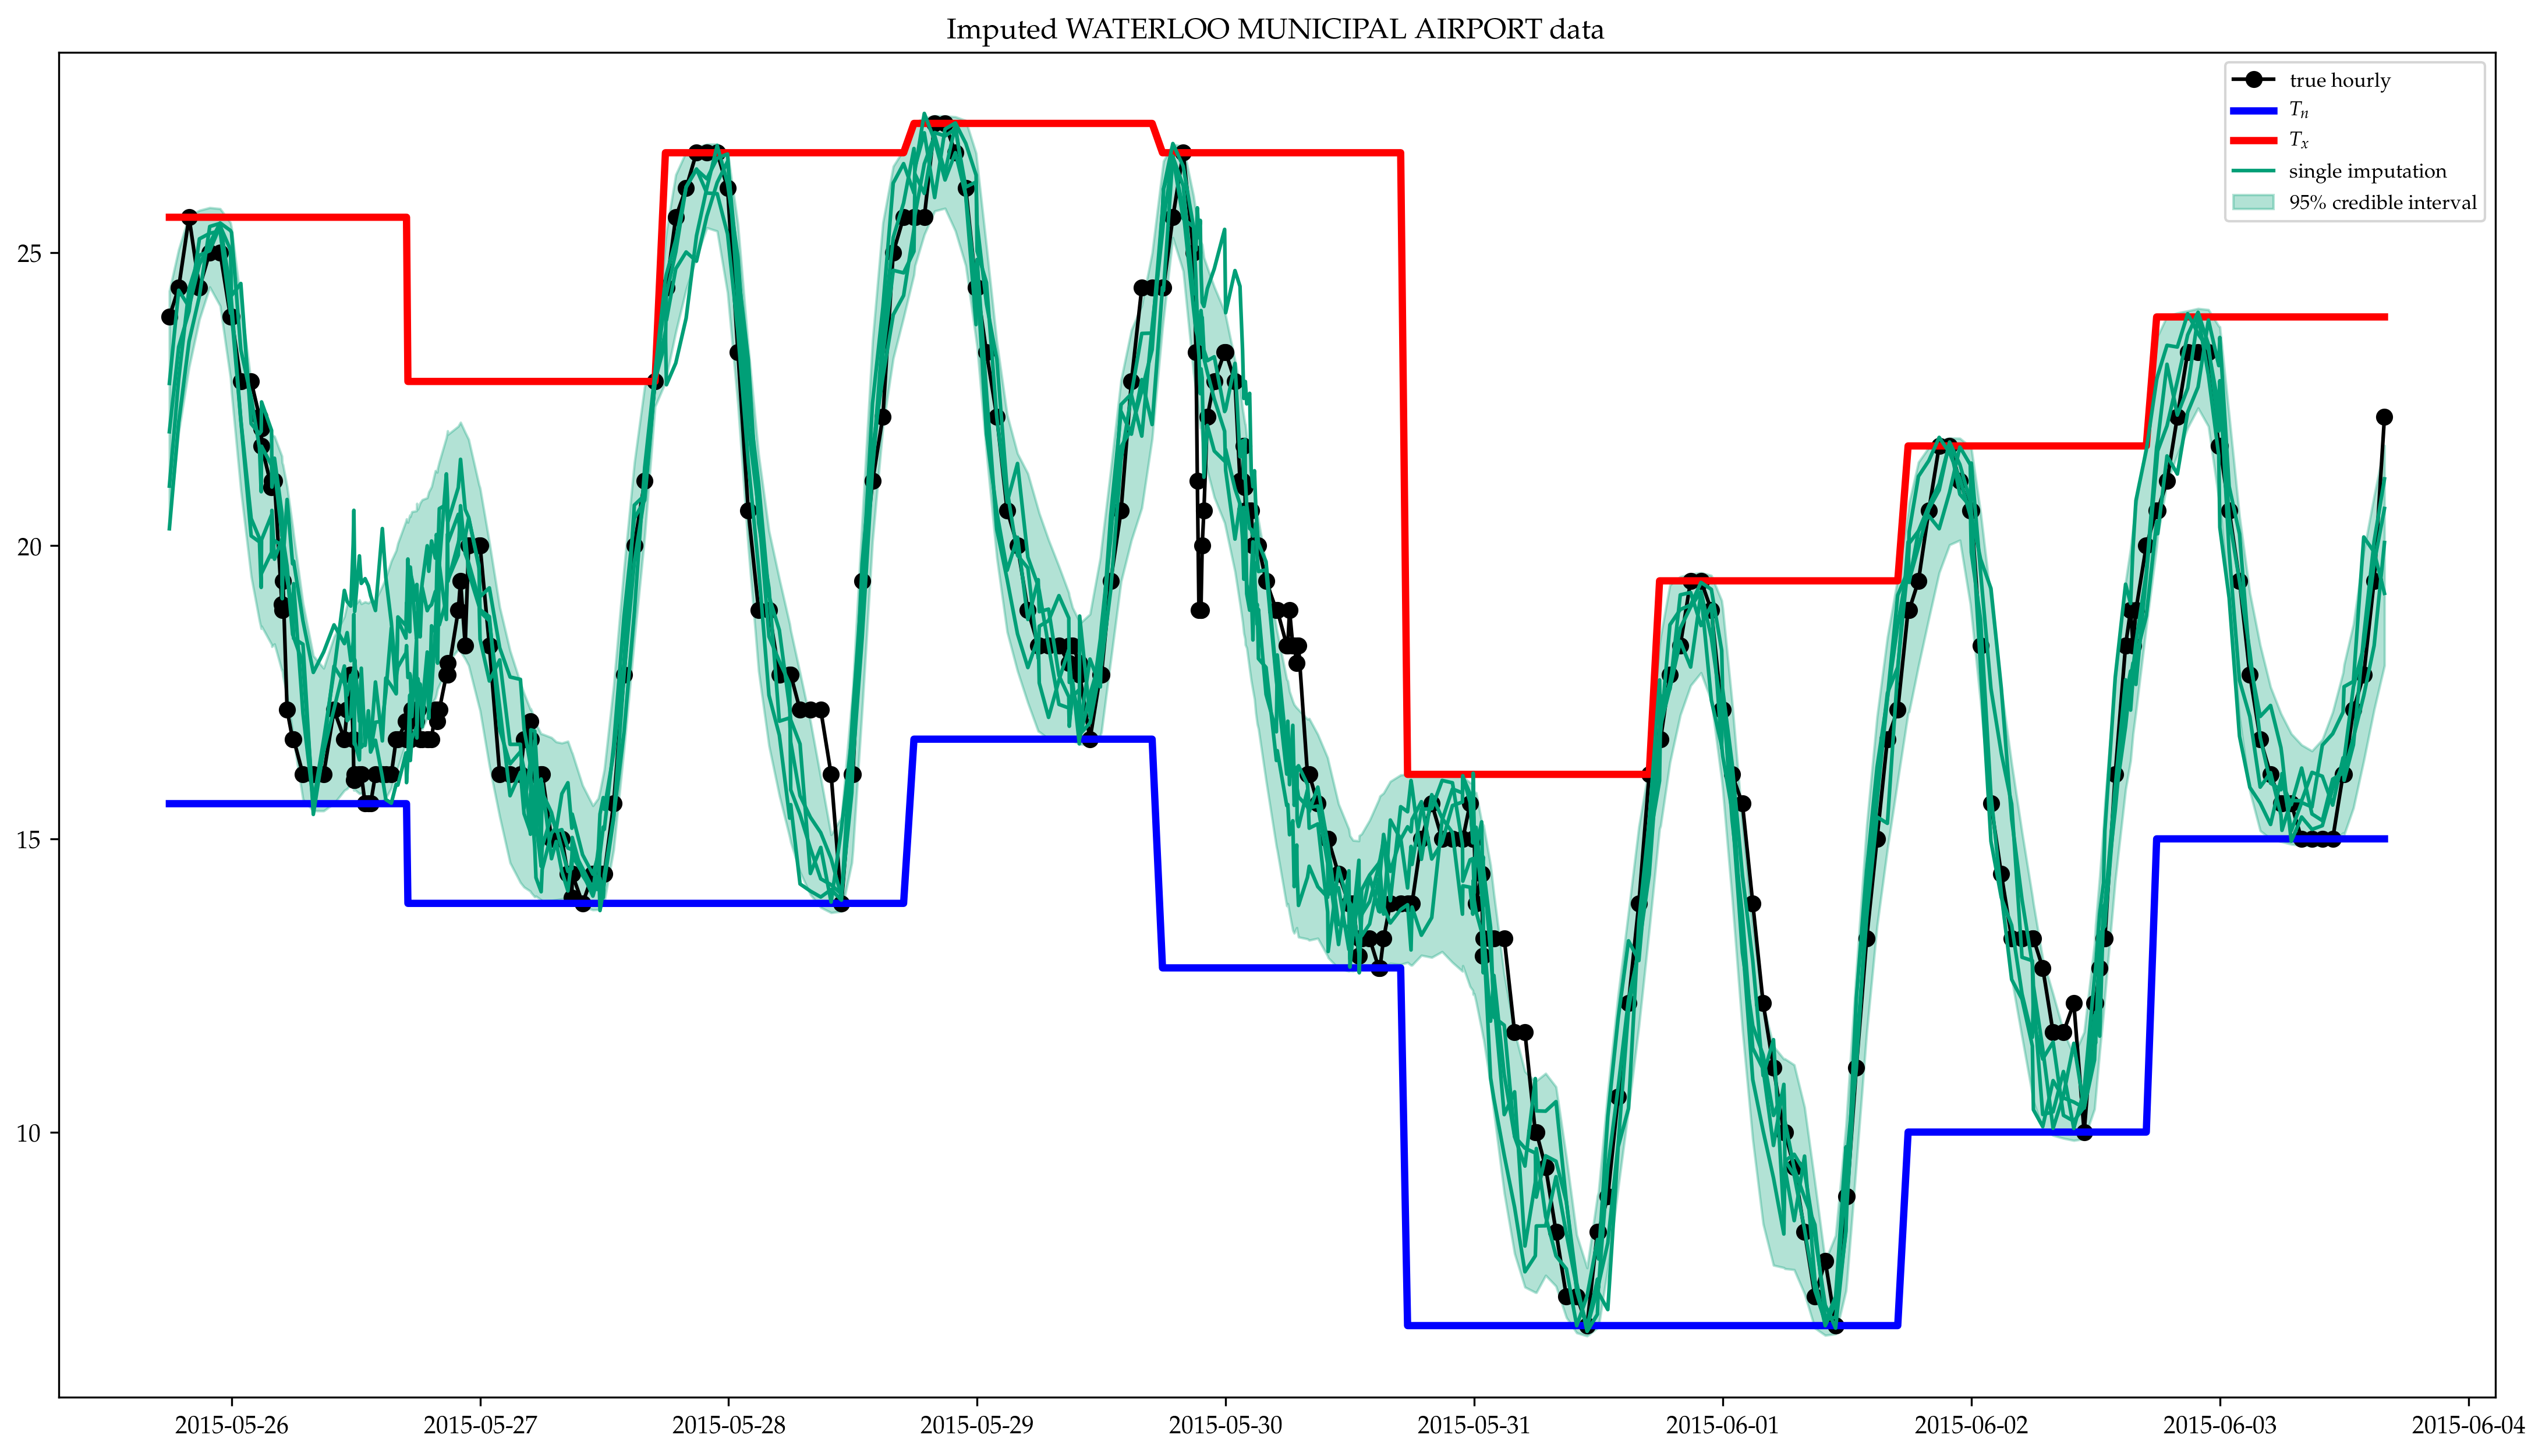

In [20]:
begin
    ts = test_subset[:ts]
    plt.plot(ts, test_subset[:temp], 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subset[:Tn], 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subset[:Tx], 
        color="red", linewidth=3, label=L"$T_x$")
    plt.fill_between(ts, imputed_025, imputed_975, 
        color="#009F77", alpha=0.3, label=L"$95\%$ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[250,:,i], color="#009F77")
    end
    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", iowa[:isdSubset][iowa[:itest],:NAME]))
end
;

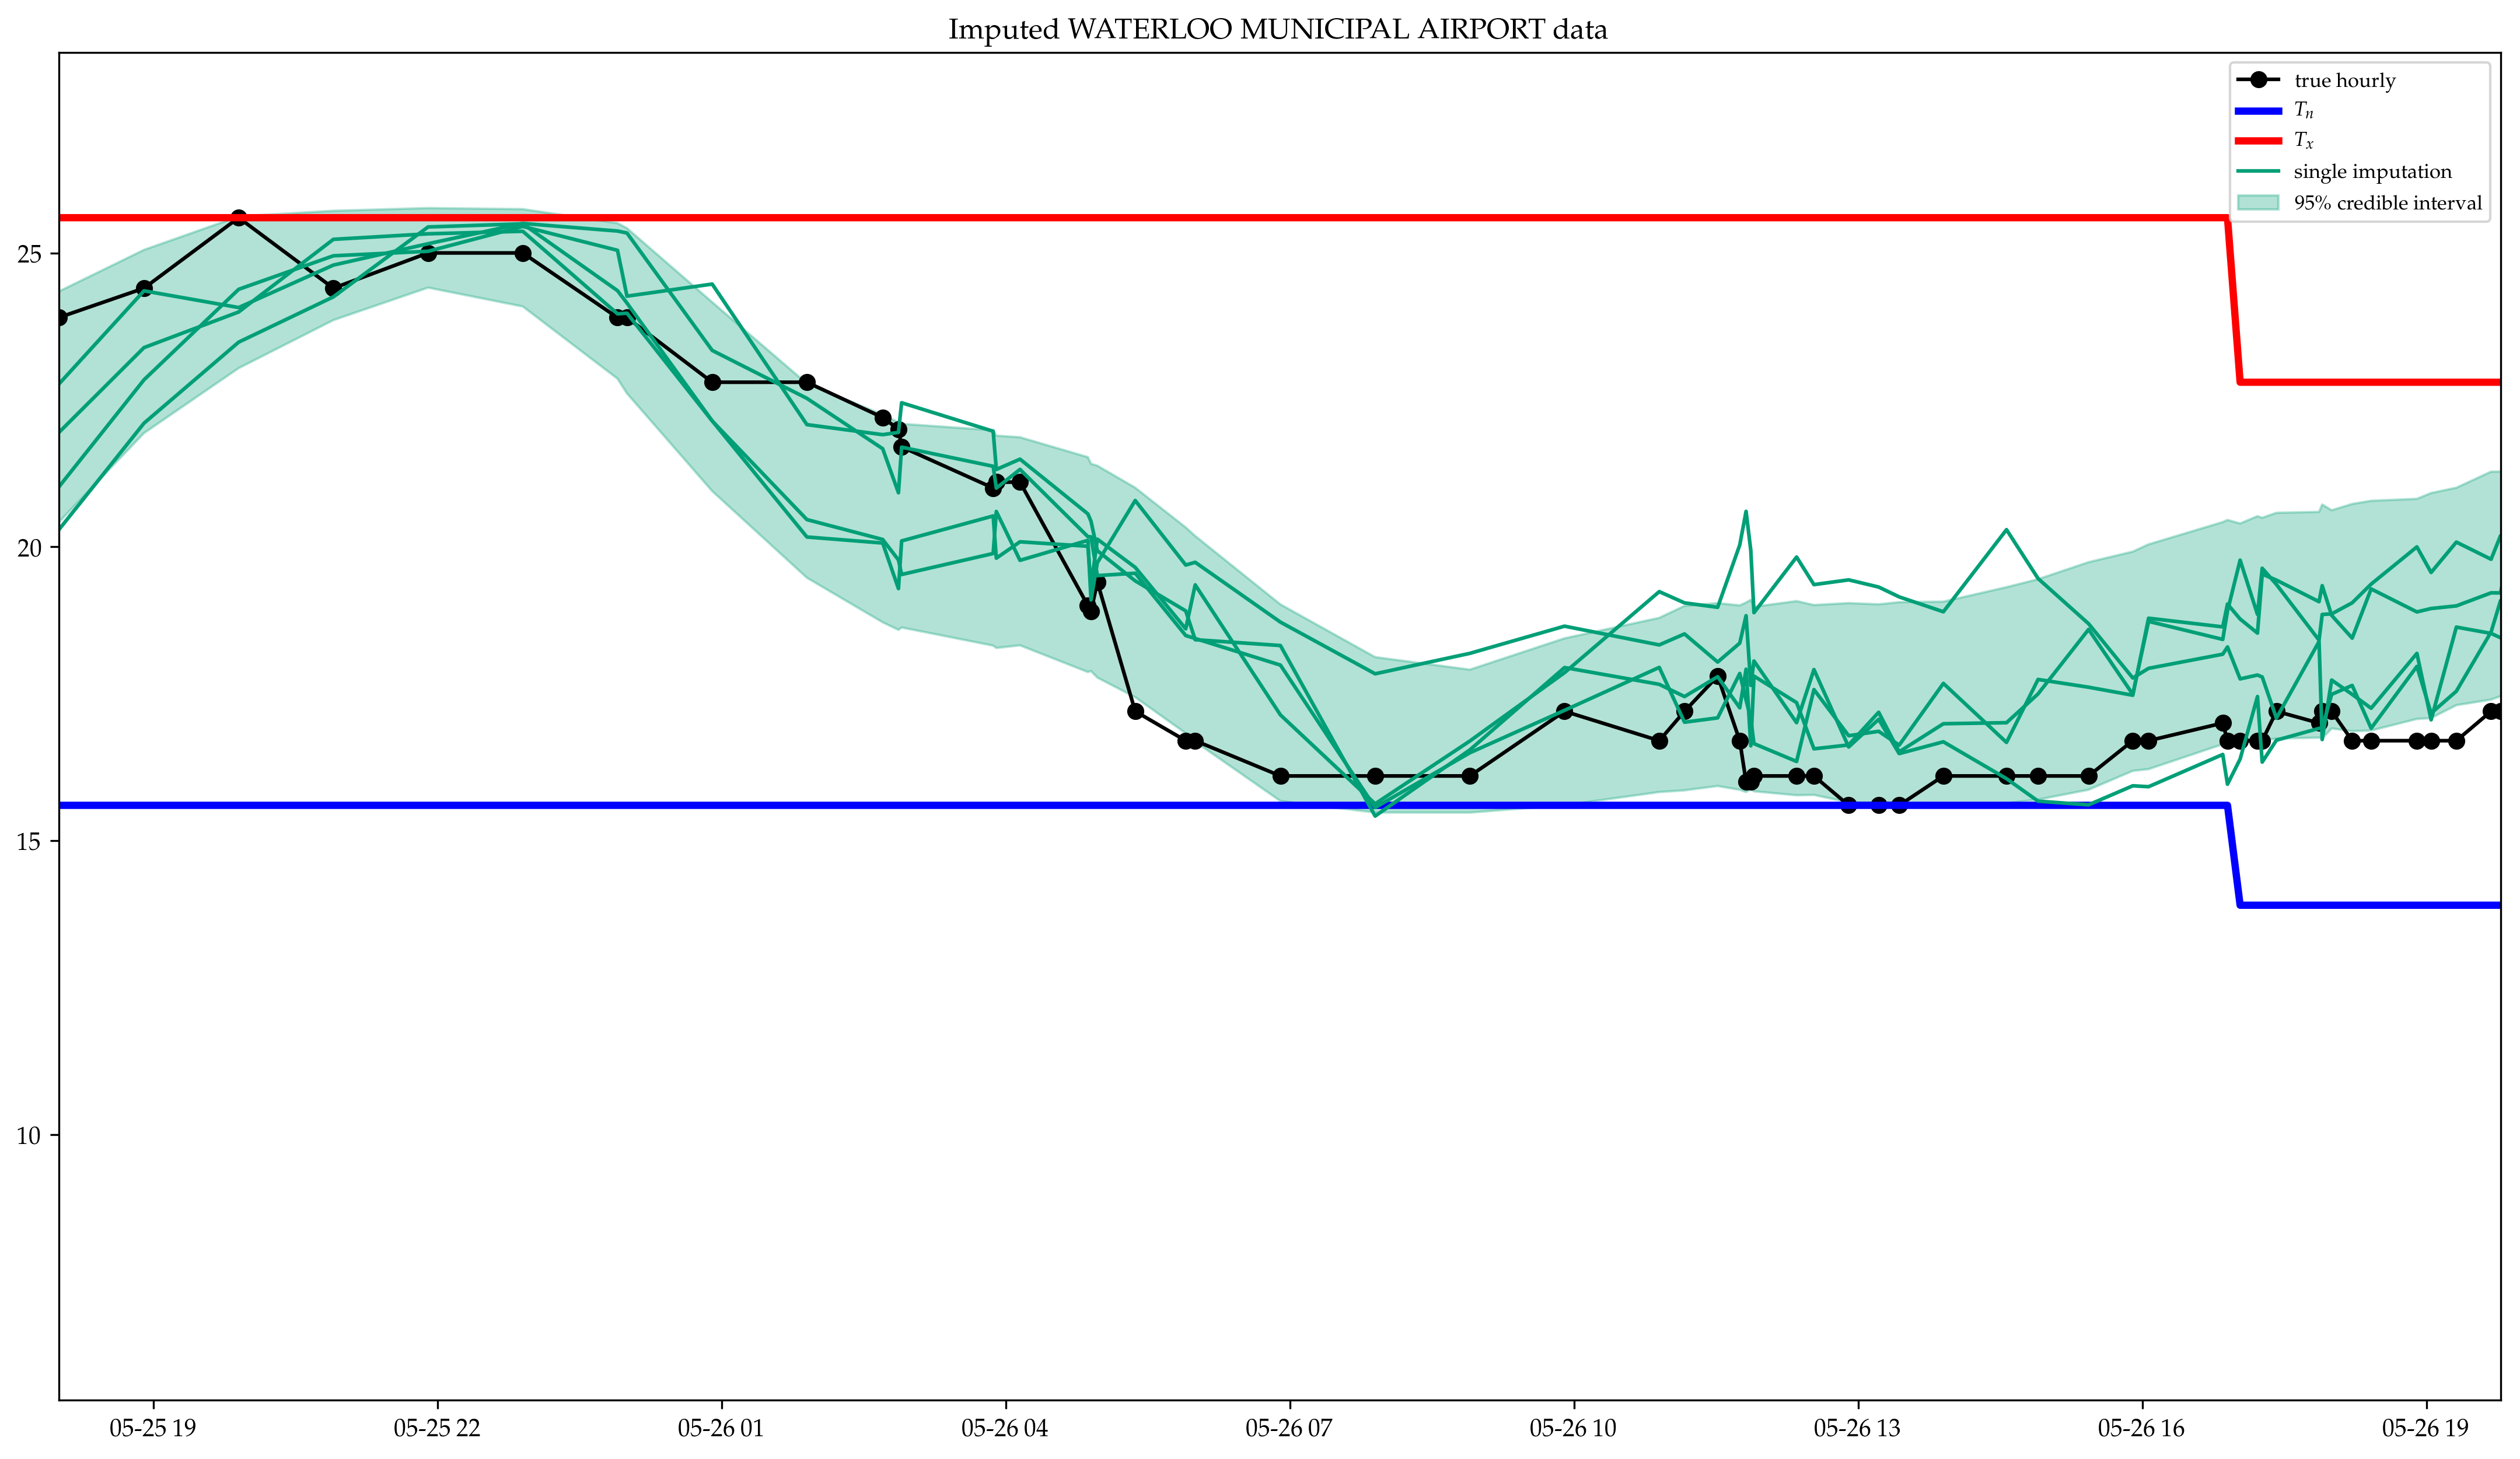

In [21]:
begin
    ts = test_subset[:ts]
    plt.plot(ts, test_subset[:temp], 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subset[:Tn], 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subset[:Tx], 
        color="red", linewidth=3, label=L"$T_x$")
    plt.fill_between(ts, imputed_025, imputed_975, 
        color="#009F77", alpha=0.3, label=L"$95\%$ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[250,:,i], color="#009F77")
    end
    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", iowa[:isdSubset][iowa[:itest],:NAME]))
    plt.xlim(ts[1], ts[60])
end
;

# Observations

Note that we've separated the imputation procedure into two separate steps, which use two separate sources of information about the temperatures:

1. the hourly temperatures at nearby stations
2. the $T_n$ and $T_x$ records at the test station

The advantage is that incorporating the nearby hourly temperatures can be done analytically once we specify a Gaussian Process model. So that step is computationally very quick. We then only use SmoothHMC in Stan to add the second source of information. 
The STAN model is therefore hugely simplified, and the fitting time is greatly reduced.

We're getting good convergence diagnostics from Stan, and the imputed temperatures:
1. stay within the constraints imposed by $T_n$ and $T_x$
2. are very close to the true temperatures at Waterloo Municipal Airport
3. on May 27th and 28th the model accurately finds that the high for both days is set in the same afternoon, and that the peak of the previous diurnal cycle does not get recorded

Sources of worry are:
* the imputed temperatures look a bit noisy: less smooth than the true temperature time series;
* the true temperatures sometimes drift out of the 95% envelope, though not necessarily more often than they should.

# Diagnosis: are imputations too noisy/wiggly

They look too noisy. Are they too noisy?

First compute the average square temperature changes in the imputed hourly temperatures.
For a single chain, this is:

$$\frac{1}{T}\sum_{t=2}^T \del{C_t - C_{t-1}}^2$$

where $C_t$ is the imputed temperature ($C$ for Celsius) at time $t$.

In [22]:
msdiff(x) = mean(diff(x).^2)

msdiff(temp_impute[1,:,1]) # single chain

1.0509292629410028

We then average over all the chains

In [23]:
mean(msdiff(temp_impute[i,:,k]) for i in 1:500 for k in 1:4)

1.0338930563700168

And then we compare this to the true temperature records:

In [24]:
msdiff(test_subset[:temp])

0.9557817109144543

~~Which confirms that our imputed temperaturs are too noisy.~~

**Update:** after some bug fixes, the imputations are smoother. In fact then mean square difference is now in line with the empirical value.